---
# Clustering and Classification using Knowledge Graph Embeddings
---
1. Creating the knowledge graph (i.e. triples) from a tabular dataset of football matches
2. Training the ComplEx embedding model on those triples
3. Evaluating the quality of the embeddings on a validation set
4. Clustering the embeddings, comparing to the natural clusters formed by the geographical continents
5. Applying the embeddings as features in classification task, to predict match results
6. Evaluating the predictive model on a out-of-time test set, comparing to a simple baseline

---

## Requirements

A Python environment with the AmpliGraph library installed.

Some sanity check:

In [ ]:
!pip install tensorflow==2.9.0
!pip install ampligraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 20.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 24.3.25
    Uninstalling flatbuffers-24.3.25:
      Successfully uninstalled flatbuffers-24.3.25
  Attempting uninstall: tensorboard-data-serve

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.3/210.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 80.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.5/575.5 kB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 562.4/562.4 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━

In [ ]:
import numpy as np
import pandas as pd
import ampligraph
import tensorflow as tf

## Dataset

We will use information on players from Italy's A series available on public domain. The json source file's structure looks like this:
[
    {
        "club_name": "SSC Napoli",
        "club_link": "https://www.transfermarkt.com/ssc-neapel/startseite/verein/6195/saison_id/2024",
        "players": [
            {
                "name": "Alex Meret",
                "position": "Goalkeeper",
                "cost": "€12.00m",
                "profile_link": "https://www.transfermarkt.com/alex-meret/leistungsdaten/spieler/240414/plus/1?saison=ges",
                "detailed_stats": {
                    "Appearances": "277",
                    "Goals": "-",
                    "Own goals": "1",
                    "Substitutions on": "3",
                    "Substitutions off": "5",
                    "Yellow cards": "3",
                    "Second yellow cards": "-",
                    "Red cards": "1",
                    "Goals conceded": "304",
                    "Clean sheets": "92",
                    "Minutes played": "24.674'"
                }
            },
            ...


In [ ]:
import requests
import json

with open("output.json", "r", encoding="UTF-8") as f:
    data = json.load(f)

In [ ]:
import re

def parse_cost(cost):
    cost = cost.replace('€', '').strip()

    match = re.match(r"([0-9\.]+)([mk]?)", cost)

    if match:
        number = float(match.group(1))
        unit = match.group(2)

        if unit == 'm':
            return number * 1_000_000
        elif unit == 'k':
            return number * 1_000
        else:
            return number
    else:
        return 0

In [ ]:
from pandas import json_normalize

players_data = []

for club in data:
    for player in club['players']:
        player_info = json_normalize(player, sep='_')
        player_info['club_name'] = club['club_name']
        player_info['club_link'] = club['club_link']
        player_info['cost'] = player_info['cost'].apply(parse_cost)
        players_data.append(player_info)

df = pd.concat(players_data, ignore_index=True)

In [ ]:
df.isna().sum()

,0
name,0
position,0
cost,0
profile_link,0
detailed_stats_Appearances,0
detailed_stats_Goals,0
detailed_stats_Own goals,0
detailed_stats_Substitutions on,0
detailed_stats_Substitutions off,0
detailed_stats_Yellow cards,0


Dropping matches with unknown score:

In [ ]:
# Replace "-" with 0 in relevant columns

columns_to_clean = [
    "detailed_stats_Appearances",
    "detailed_stats_Goals",
    "detailed_stats_Own goals",
    "detailed_stats_Assists",
    "detailed_stats_Substitutions on",
    "detailed_stats_Substitutions off",
    "detailed_stats_Yellow cards",
    "detailed_stats_Second yellow cards",
    "detailed_stats_Red cards",
    "detailed_stats_Goals conceded",
    "detailed_stats_Clean sheets",
    "detailed_stats_Penalty goals"
]

# Convert all columns to numeric, converting NaNs to 0
df[columns_to_clean] = df[columns_to_clean].apply(pd.to_numeric, errors='coerce').fillna(0)

df['detailed_stats_Minutes played'] = df['detailed_stats_Minutes played'].astype(str)
df['detailed_stats_Minutes per goal'] = df['detailed_stats_Minutes per goal'].astype(str)

df['detailed_stats_Minutes played'] = df['detailed_stats_Minutes played'].str.replace("'", "", regex=False)
df['detailed_stats_Minutes per goal'] = df['detailed_stats_Minutes per goal'].str.replace("'", "", regex=False)

df['detailed_stats_Minutes played'] = pd.to_numeric(df['detailed_stats_Minutes played'], errors='coerce')
df['detailed_stats_Minutes per goal'] = pd.to_numeric(df['detailed_stats_Minutes per goal'], errors='coerce')

The training set will be a random shuffle of 70 percent of the dataset

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
df['train'] = df.index.isin(train_df.index)

In [ ]:
df['train'].value_counts()

,count
train,
True,407
False,175


## Knowledge graph creation
We are going to create a knowledge graph from scratch based on the player information. The idea is that each player is an entity that will be connected to its club and stats.

The objective is to generate a new representation of the dataset where each data point is an triple in the form:

    <subject, predicate, object>
    
First we need to create the entities (subjects and objects) that will form the graph.

In [ ]:
# Entities naming
df["player_id"] = df.index.values.astype(str)
df["player_id"] = "Player" + df.player_id
df["club_id"] = df.club_name.str.title().str.replace(" ", "")
df["club_id"] = "Club" + df.club_id
df["stats_id"] = df.index.values.astype(str)
df["stats_id"] = "Stats" + df["stats_id"]

Then, we create the actual triples based on the relationship between the entities. We do it only for the triples in the training set.

In [ ]:
triples = []
for _, row in df[df["train"]].iterrows():
    player_club = (row["player_id"], "belongsToClub", row["club_id"])
    player_name = (row["player_id"], "hasName", row["name"])
    player_position = (row["player_id"], "hasPosition", row["position"])
    player_cost = (row["player_id"], "hasCost", row["cost"])
    player_profile_link = (row["player_id"], "hasProfileLink", row["profile_link"])

    club_name = (row["club_id"], "clubName", row["club_name"])
    club_link = (row["club_id"], "clubLink", row["club_link"])

    player_stats = (row["player_id"], "hasStats", row["stats_id"])

    appearances = (row["stats_id"], "appearances", row["detailed_stats_Appearances"])
    goals = (row["stats_id"], "goals", row["detailed_stats_Goals"])
    own_goals = (row["stats_id"], "ownGoals", row["detailed_stats_Own goals"])
    substitutions_on = (row["stats_id"], "substitutionsOn", row["detailed_stats_Substitutions on"])
    substitutions_off = (row["stats_id"], "substitutionsOff", row["detailed_stats_Substitutions off"])
    yellow_cards = (row["stats_id"], "yellowCards", row["detailed_stats_Yellow cards"])
    second_yellow_cards = (row["stats_id"], "secondYellowCards", row["detailed_stats_Second yellow cards"])
    red_cards = (row["stats_id"], "redCards", row["detailed_stats_Red cards"])
    goals_conceded = (row["stats_id"], "goalsConceded", row["detailed_stats_Goals conceded"])
    assists = (row["stats_id"], "assists", row["detailed_stats_Assists"])
    clean_sheets = (row["stats_id"], "cleanSheets", row["detailed_stats_Clean sheets"])
    minutes_played = (row["stats_id"], "minutesPlayed", row["detailed_stats_Minutes played"])
    penalty_goals = (row["stats_id"], "penaltyGoals", row["detailed_stats_Penalty goals"])
    minutes_per_goal = (row["stats_id"], "minutesPerGoal", row["detailed_stats_Minutes per goal"])

    triples.extend([
        player_club, player_name, player_position, player_cost, player_profile_link,
        club_name, club_link,
        player_stats,
        appearances, goals, own_goals, substitutions_on, substitutions_off,
        yellow_cards, second_yellow_cards, red_cards, goals_conceded,
        clean_sheets, minutes_played, penalty_goals, minutes_per_goal, assists
    ])

The whole graph related to a randomly chosen Player with id of 139 can be summarised by the triples below:

In [ ]:
triples_df = pd.DataFrame(triples, columns=["subject", "predicate", "object"])
triples_df = triples_df.drop_duplicates()
triples_df[(triples_df.subject == "Stats139") | (triples_df.subject == "Player139") | (triples_df.subject == "ClubBolognaFc1909")]

,subject,predicate,object
1523,ClubBolognaFc1909,clubName,Bologna FC 1909
1524,ClubBolognaFc1909,clubLink,https://www.transfermarkt.com/fc-bologna/start...
2002,Player139,belongsToClub,ClubBolognaFc1909
2003,Player139,hasName,Thijs Dallinga
2004,Player139,hasPosition,Centre-Forward
2005,Player139,hasCost,15000000.0
2006,Player139,hasProfileLink,https://www.transfermarkt.com/thijs-dallinga/l...
2009,Player139,hasStats,Stats139
2010,Stats139,appearances,218
2011,Stats139,goals,108.0


## Example RML mapping


In [ ]:
# @prefix rr: <http://www.w3.org/ns/r2rml#>.
# @prefix rml: <http://semweb.mmlab.be/ns/rml#>.
# @prefix ql: <http://semweb.mmlab.be/ns/ql#>.
# @prefix xsd: <http://www.w3.org/2001/XMLSchema#>.
# @prefix ex: <http://example.com/ns#>.
# @prefix dbo: <http://dbpedia.org/ontology#/>.

# <#ClubMapping>
#   rml:logicalSource [
#     rml:source "output.json";
#     rml:referenceFormulation ql:JSONPath;
#     rml:iterator "$[*]"  # Iterate over the root array for clubs
#   ];

#   rr:subjectMap [
#     rr:template "http://ex.com/Club/{club_name}";
#     rr:class dbo:Club
#   ];

#   rr:predicateObjectMap [
#     rr:predicate ex:clubName;
#     rr:objectMap [
#       rml:reference "$.club_name"
#     ]
#   ];

#   rr:predicateObjectMap [
#     rr:predicate ex:clubLink;
#     rr:objectMap [
#       rml:reference "$.club_link"
#     ]
#   ].

# <#PlayerMapping>
#   rml:logicalSource [
#     rml:source "output.json";
#     rml:referenceFormulation ql:JSONPath;
#     rml:iterator "$[*].players[*]"
#   ];

#   rr:subjectMap [
#     rr:template "http://ex.com/Player/{name}";
#     rr:class dbo:Player
#   ];

#   rr:predicateObjectMap [
#     rr:predicate ex:hasName;
#     rr:objectMap [
#       rml:reference "$.name"
#     ]
#   ];

#   rr:predicateObjectMap [
#     rr:predicate ex:hasPosition;
#     rr:objectMap [
#       rml:reference "$.position"
#     ]
#   ];

#   rr:predicateObjectMap [
#     rr:predicate ex:hasCost;
#     rr:objectMap [
#       rml:reference "$.cost"
#     ]
#   ];

#   rr:predicateObjectMap [
#     rr:predicate ex:hasProfileLink;
#     rr:objectMap [
#       rml:reference "$.profile_link"
#     ]
#   ];

#   rr:predicateObjectMap [
#     rr:predicate ex:playsForClub;
#     rr:objectMap [
#       rr:parentTriplesMap <#ClubMapping>;
#     ]
#   ].


## Training knowledge graph embeddings

We split our training dataset further into training and validation, where the new training set will be used to the knowledge embedding training and the validation set will be used in its evaluation. The test set will be used to evaluate the performance of the classification algorithm built on top of the embeddings.

What differs from the standard method of randomly sampling N points to make up our validation set is that our data points are two entities linked by some relationship, and we need to take care to ensure that all entities are represented in train and validation sets by at least one triple.

To accomplish this, AmpliGraph provides the [`train_test_split_no_unseen`](https://docs.ampligraph.org/en/latest/generated/ampligraph.evaluation.train_test_split_no_unseen.html#train-test-split-no-unseen) function.

In [ ]:
from ampligraph.evaluation import train_test_split_no_unseen
import math

X_train, X_valid = train_test_split_no_unseen(np.array(triples), test_size=math.floor(0.2 * len(triples)))

In [ ]:
print('Train set size: ', X_train.shape)
print('Test set size: ', X_valid.shape)

Train set size:  (7164, 3)
Test set size:  (1790, 3)


In [ ]:
from ampligraph.latent_features import ScoringBasedEmbeddingModel
from ampligraph.latent_features.loss_functions import get as get_loss
from ampligraph.latent_features.regularizers import get as get_regularizer

model = ScoringBasedEmbeddingModel(k=100,
                                   eta=20,
                                   scoring_type='ComplEx',
                                   seed=0)

# Optimizer, loss and regularizer definition
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = get_loss('multiclass_nll')
regularizer = get_regularizer('LP', {'p': 3, 'lambda': 1e-5})

# Compilation of the model
model.compile(optimizer=optimizer, loss=loss, entity_relation_regularizer=regularizer)

AmpliGraph has implemented [several Knowledge Graph Embedding models](https://docs.ampligraph.org/en/latest/ampligraph.latent_features.html#knowledge-graph-embedding-models) (TransE, ComplEx, DistMult, HolE), but to begin with we're just going to use the [ComplEx](https://docs.ampligraph.org/en/latest/generated/ampligraph.latent_features.ComplEx.html#ampligraph.latent_features.ComplEx) model, which is known to bring state-of-the-art predictive power.

The hyper-parameter choice was based on the [best results](https://docs.ampligraph.org/en/latest/experiments.html) we have found so far for the ComplEx model applied to some benchmark datasets used in the knowledge graph embeddings community. This tutorial does not cover [hyper-parameter tuning](https://docs.ampligraph.org/en/latest/examples.html#model-selection).

Lets go through the parameters to understand what's going on:

- **`k`**: the dimensionality of the embedding space.
- **`eta`** ($\\eta$) : the number of negative, or false triples that must be generated at training runtime for each positive, or true triple.
- **`scoring_type`**: type of model defined by spicific scoring function.
- **`seed`** : random seed, used for reproducibility.
- **`optimizer`** : the Adam optimizer, with a learning rate of 1e-4 set via the *optimizer_params* kwarg.
- **`loss`** : pairwise loss, with a margin of 0.5 set via the *loss_params* kwarg.
- **`regularizer`** : $L_p$ regularization with $p=3$, i.e. l3 regularization. $\\lambda$ = 1e-5, set via the *regularizer_params* kwarg.

Training should take around 10 minutes:

In [ ]:
model.fit(X_train,
          batch_size=int(X_train.shape[0] / 50),
          epochs=300, # Number of training epochs
          verbose=True # Displays a progress bar.
          )

Epoch 1/300
52/52 [==============================] - 4s 86ms/step - loss: 427.6563
Epoch 2/300
52/52 [==============================] - 1s 20ms/step - loss: 427.6242
Epoch 3/300
52/52 [==============================] - 1s 20ms/step - loss: 427.5919
Epoch 4/300
52/52 [==============================] - 1s 21ms/step - loss: 427.5576
Epoch 5/300
52/52 [==============================] - 1s 20ms/step - loss: 427.5205
Epoch 6/300
52/52 [==============================] - 1s 20ms/step - loss: 427.4796
Epoch 7/300
52/52 [==============================] - 1s 21ms/step - loss: 427.4341
Epoch 8/300
52/52 [==============================] - 1s 21ms/step - loss: 427.3831
Epoch 9/300
52/52 [==============================] - 1s 20ms/step - loss: 427.3252
Epoch 10/300
52/52 [==============================] - 2s 29ms/step - loss: 427.2592
Epoch 11/300
52/52 [==============================] - 1s 25ms/step - loss: 427.1837
Epoch 12/300
52/52 [==============================] - 1s 20ms/step - loss: 427.0971
E

## Evaluating knowledge embeddings

AmpliGraph aims to follow scikit-learn's ease-of-use design philosophy and simplify everything down to **`fit`**, **`evaluate`**, and **`predict`** functions.

However, there are some knowledge graph specific steps we must take to ensure our model can be trained and evaluated correctly. The first of these is defining the filter that will be used to ensure that no negative statements generated by the corruption procedure are actually positives. This is simply can be done by concatenating our train and test sets. Now when negative triples are generated by the corruption strategy, we can check that they aren't actually true statements.

For this we'll use method `evaluate` of model object:

- **`X_valid`** - the data to evaluate on. We're going to use our test set to evaluate.
- **`use_filter`** - will filter out the false negatives generated by the corruption strategy.
- **`corrupt_side`** - specifies approach for triple corruption. 's,o' option means t True, then subj and obj are corrupted separately during evaluation.
- **`verbose`** - displays a progress bar.

In [ ]:
ranks = model.evaluate(X_valid,
                      use_filter={'train': X_train,
                                  'test': X_valid},
                      corrupt_side='s,o',
                      verbose=True)

180/180 [==============================] - 21s 116ms/step


We're going to use the mrr_score (mean reciprocal rank) and hits_at_n_score functions.

- **mrr_score**: The function computes the mean of the reciprocal of elements of a vector of rankings ranks.
- **hits_at_n_score**: The function computes how many elements of a vector of rankings ranks make it to the top n positions.

In [ ]:
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score

mr = mr_score(ranks)
mrr = mrr_score(ranks)

print("MRR: %.2f" % (mrr))
print("MR: %.2f" % (mr))

hits_10 = hits_at_n_score(ranks, n=10)

print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

MRR: inf
MR: 216.12
Hits@10: 0.39
Hits@3: 0.32
Hits@1: 0.27


/usr/local/lib/python3.10/dist-packages/ampligraph/evaluation/metrics.py:152: RuntimeWarning: divide by zero encountered in divide
  return np.sum(1 / ranks) / len(ranks)


We can interpret these results by stating that the model will rank the correct entity within the top-3 possibilities 34% of the time.

By themselves, these metrics are not enough to conclude the usefulness of the embeddings in a downstream task, but they suggest that the embeddings have learned a reasonable representation enough to consider using them in more tasks.

## Clustering and embedding visualization

To evaluate the subjective quality of the embeddings, we can visualise the embeddings on 2D space and also cluster them on the original space. We can compare the clustered embeddings with natural clusters, in this case the continent where the team is from, so that we have a ground truth to evaluate the clustering quality both qualitatively and quantitatively.

Requirements:

* seaborn
* adjustText
* incf.countryutils

For seaborn and adjustText, simply install them with `pip install seaborn adjustText`.

For incf.countryutils, do the following steps:
```bash
git clone https://github.com/wyldebeast-wunderliebe/incf.countryutils.git
cd incf.countryutils
pip install .```

In [ ]:
!pip install adjustText

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
%matplotlib inline

 We create a map from the team ID (e.g. "TeamBrazil") to the team name (e.g. "Brazil") for visualization purposes.

In [ ]:

id_to_name_map = {**dict(zip(df.player_id, df.name))}

We now create a dictionary with the embeddings of all teams:

In [ ]:
players = df.player_id[df["train"]].unique()
player_embeddings = dict(zip(players, model.get_embeddings(players)))

We use PCA to project the embeddings from the 200 space into 2D space:

In [ ]:
embeddings_2d = PCA(n_components=2).fit_transform(np.array([i for i in player_embeddings.values()]))

We will cluster the teams embeddings on its original 200-dimensional space using the `find_clusters` in our discovery API:

In [ ]:
from ampligraph.discovery import find_clusters
from sklearn.cluster import KMeans

clustering_algorithm = KMeans(n_clusters=13, n_init=50, max_iter=500, random_state=0)
clusters = find_clusters(players, model, clustering_algorithm, mode='e')

This helper function uses the `incf.countryutils` library to translate country names to their corresponding continents.

In [ ]:
player_positions = dict(zip(df.player_id, df.position))

This dataframe contains for each team their projected embeddings to 2D space via PCA, their continent and the KMeans cluster. This will be used alongisde Seaborn to make the visualizations.

In [ ]:
plot_df = pd.DataFrame({
    "players": [id_to_name_map[player_id] for player_id in players],
    "embedding1": embeddings_2d[:, 0],  # First PCA dimension
    "embedding2": embeddings_2d[:, 1],  # Second PCA dimension
    "position": [player_positions[player] for player in players],  # Map player positions
    "cluster": ["cluster" + str(cluster) for cluster in clusters]  # Assign cluster labels
})

We plot the results on a 2D scatter plot, coloring the teams by the continent or cluster and also displaying some individual team names.

We always display the names of the top 20 teams (according to [FIFA rankings](https://en.wikipedia.org/wiki/FIFA_World_Rankings)) and a random subset of the rest.

In [ ]:
def plot_clusters(hue, random_percentage=0.1):
    np.random.seed(0)
    plt.figure(figsize=(12, 12))
    plt.title("{} embeddings".format(hue).capitalize())

    # Scatterplot based on embeddings with hue as player position or cluster
    ax = sns.scatterplot(data=plot_df[plot_df.position != "unk"], x="embedding1", y="embedding2", hue=hue)

    texts = []

    # Annotating random players (10% or as specified)
    for i, point in plot_df.iterrows():
        if np.random.random() < random_percentage:  # Randomly choose players to annotate
            texts.append(plt.text(point['embedding1'] + 0.02, point['embedding2'] + 0.01, str(point["players"])))

    # Adjust text to avoid overlap
    adjust_text(texts)

The first visualisation of the 2D embeddings shows the natural geographical clusters (continents), which can be seen as a form of the ground truth:

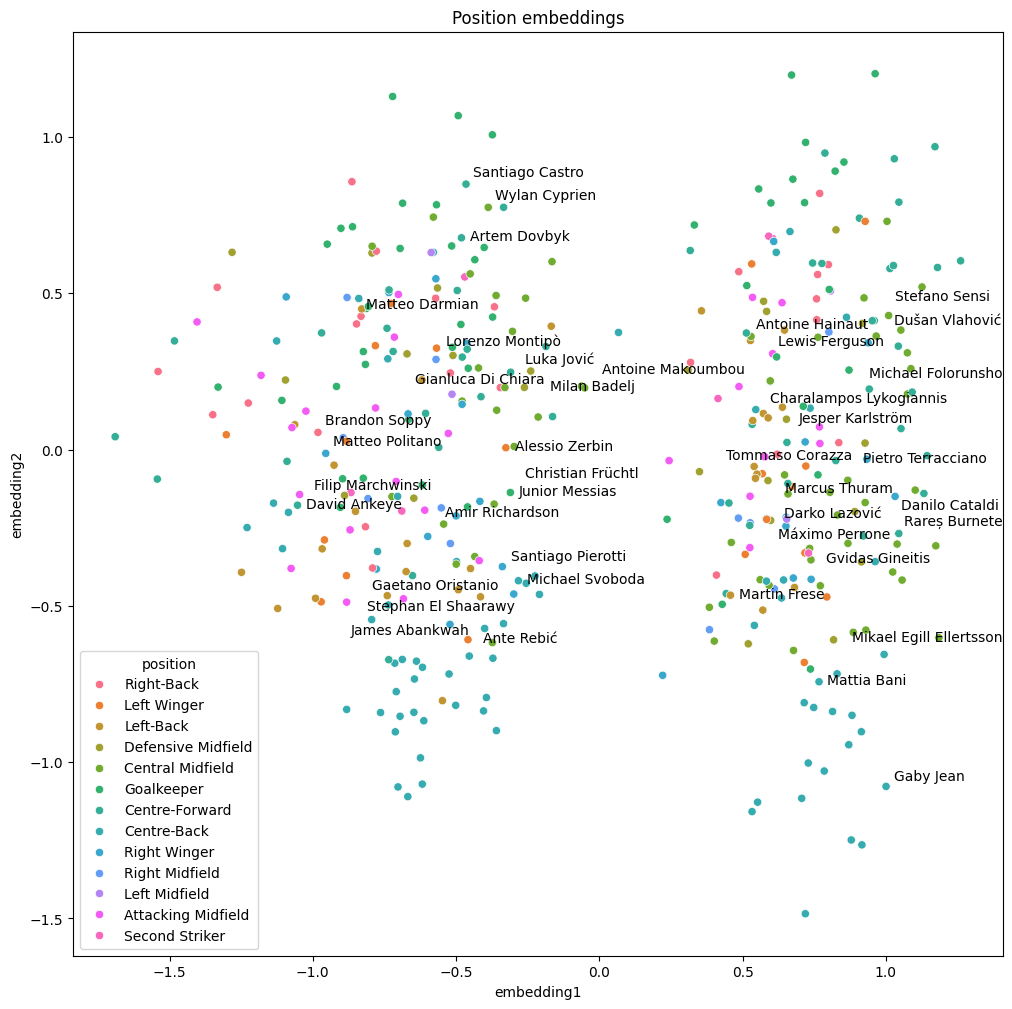

In [ ]:
plot_clusters("position")

We can see above that the embeddings learned geographical similarities even though this information was not explicit on the original dataset.

Now we plot the same 2D embeddings but with the clusters found by K-Means:

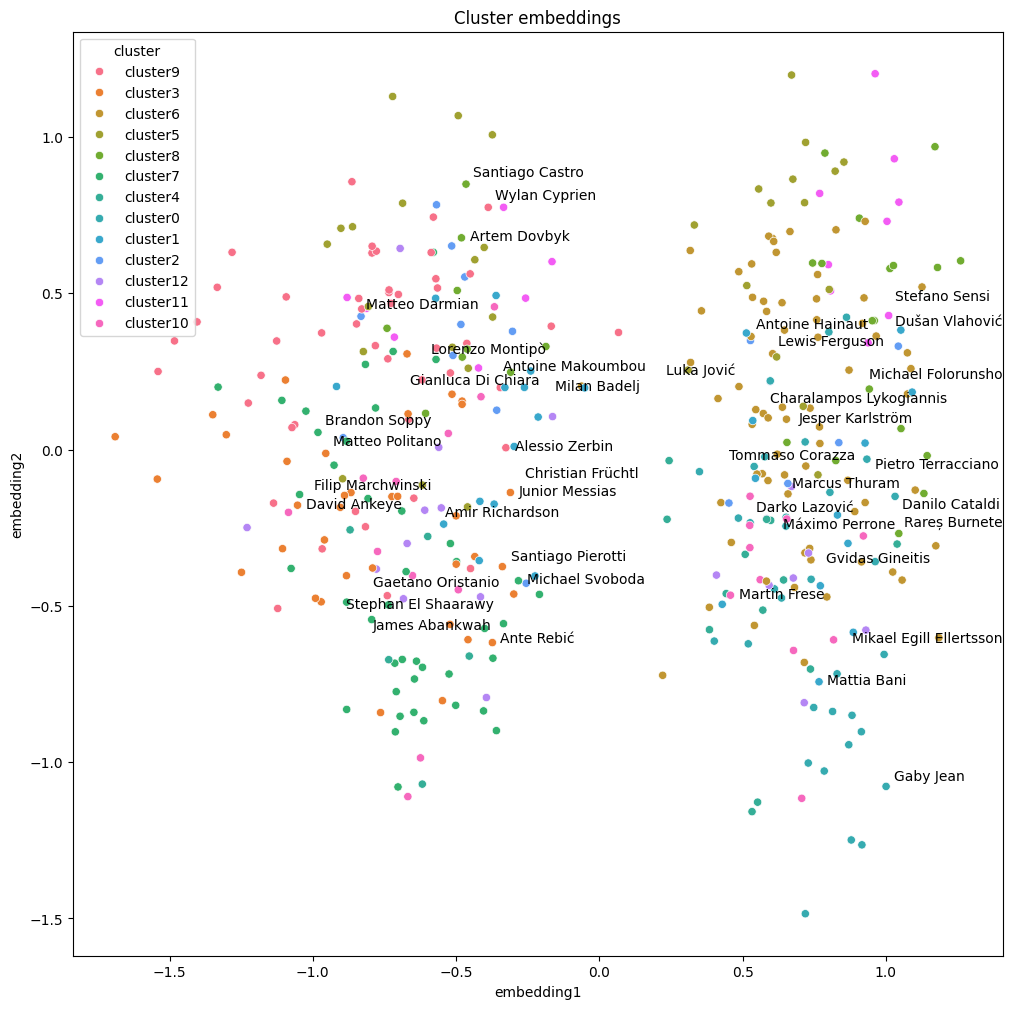

In [ ]:
plot_clusters("cluster")

We can see that K-Means found very similar cluster to the natural geographical clusters by the continents. This shows that on the 200-dimensional embedding space, similar teams appear close together, which can be captured by a clustering algorithm.

Our evaluation of the clusters can be more objective by using a metric such as the [adjusted Rand score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html), which varies from -1 to 1, where 0 is random labelling and 1 is a perfect match:

In [ ]:
from sklearn import metrics
metrics.adjusted_rand_score(plot_df.position, plot_df.cluster)

0.153735007937948

## Classification
We will use the knowledge embeddings to predict future matches as a classification problem.

We can model it as a multiclass problem with three classes: home team wins, home team loses, draw.

The embeddings are used directly as features to a XGBoost classifier.

First we need to determine the target:

In [ ]:
df["cost_class"] = (df.cost < 3000000).astype(int) + \
                ((3000000 <= df.cost) & (df.cost < 7000000)).astype(int)*2 + \
                (df.cost >= 7000000).astype(int)*3 - 1

In [ ]:
df.cost_class.value_counts(normalize=True)

,proportion
cost_class,
0,0.410653
2,0.340206
1,0.249141


### Original dataset

First install xgboost with `pip install xgboost`.

In [ ]:
!pip install xgboost

In [ ]:
features = [
    "detailed_stats_Goals",
    "detailed_stats_Own goals",
    "detailed_stats_Assists",
    "detailed_stats_Substitutions on",
    "detailed_stats_Substitutions off",
    "detailed_stats_Yellow cards",
    "detailed_stats_Second yellow cards",
    "detailed_stats_Red cards",
    "detailed_stats_Goals conceded",
    "detailed_stats_Clean sheets",
    "detailed_stats_Minutes played",
    "detailed_stats_Penalty goals",
    "detailed_stats_Minutes per goal",
]

new_df = df[features + ["cost_class"]].copy()
new_df

,detailed_stats_Goals,detailed_stats_Own goals,detailed_stats_Assists,detailed_stats_Substitutions on,detailed_stats_Substitutions off,detailed_stats_Yellow cards,detailed_stats_Second yellow cards,detailed_stats_Red cards,detailed_stats_Goals conceded,detailed_stats_Clean sheets,detailed_stats_Minutes played,detailed_stats_Penalty goals,detailed_stats_Minutes per goal,cost_class
0,0.0,1.0,0.0,3.0,5.0,3.0,0.0,1.0,304.0,92.0,24.674,0.0,NaN,2
1,10.0,0.0,19.0,92.0,97.0,37.0,1.0,1.0,0.0,0.0,20.548,0.0,2.055,1
2,4.0,2.0,1.0,11.0,3.0,24.0,1.0,0.0,0.0,0.0,8.404,0.0,2.101,2
3,52.0,0.0,52.0,45.0,111.0,30.0,1.0,0.0,0.0,0.0,15.365,5.0,295.000,2
4,6.0,2.0,14.0,38.0,37.0,39.0,2.0,0.0,0.0,0.0,15.545,0.0,2.591,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,33.0,0.0,21.0,27.0,37.0,7.0,0.0,0.0,0.0,0.0,5.388,3.0,163.000,1
578,91.0,0.0,19.0,61.0,96.0,21.0,0.0,2.0,0.0,0.0,19.129,17.0,210.000,2
579,80.0,1.0,38.0,120.0,128.0,28.0,1.0,0.0,0.0,0.0,24.900,2.0,311.000,0
580,80.0,0.0,72.0,139.0,165.0,88.0,3.0,2.0,0.0,0.0,24.814,9.0,310.000,1


Apply one hot encoding:

In [ ]:
encoded_cols = pd.get_dummies(df[["position", "club_name"]])
encoded_cols

,position_Attacking Midfield,position_Central Midfield,position_Centre-Back,position_Centre-Forward,position_Defensive Midfield,position_Goalkeeper,position_Left Midfield,position_Left Winger,position_Left-Back,position_Right Midfield,...,club_name_Hellas Verona,club_name_Inter Milan,club_name_Juventus FC,club_name_Parma Calcio 1913,club_name_SS Lazio,club_name_SSC Napoli,club_name_Torino FC,club_name_US Lecce,club_name_Udinese Calcio,club_name_Venezia FC
0,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
3,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False
4,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
578,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
579,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
580,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
new_df = new_df.join(encoded_cols)
new_df

,detailed_stats_Goals,detailed_stats_Own goals,detailed_stats_Assists,detailed_stats_Substitutions on,detailed_stats_Substitutions off,detailed_stats_Yellow cards,detailed_stats_Second yellow cards,detailed_stats_Red cards,detailed_stats_Goals conceded,detailed_stats_Clean sheets,...,club_name_Hellas Verona,club_name_Inter Milan,club_name_Juventus FC,club_name_Parma Calcio 1913,club_name_SS Lazio,club_name_SSC Napoli,club_name_Torino FC,club_name_US Lecce,club_name_Udinese Calcio,club_name_Venezia FC
0,0.0,1.0,0.0,3.0,5.0,3.0,0.0,1.0,304.0,92.0,...,False,False,False,False,False,True,False,False,False,False
1,10.0,0.0,19.0,92.0,97.0,37.0,1.0,1.0,0.0,0.0,...,False,False,False,False,False,True,False,False,False,False
2,4.0,2.0,1.0,11.0,3.0,24.0,1.0,0.0,0.0,0.0,...,False,False,False,False,False,True,False,False,False,False
3,52.0,0.0,52.0,45.0,111.0,30.0,1.0,0.0,0.0,0.0,...,False,False,False,False,False,True,False,False,False,False
4,6.0,2.0,14.0,38.0,37.0,39.0,2.0,0.0,0.0,0.0,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,33.0,0.0,21.0,27.0,37.0,7.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
578,91.0,0.0,19.0,61.0,96.0,21.0,0.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
579,80.0,1.0,38.0,120.0,128.0,28.0,1.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
580,80.0,0.0,72.0,139.0,165.0,88.0,3.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False


Create a multiclass model:

In [ ]:
from xgboost import XGBClassifier

In [ ]:
clf_model = XGBClassifier(n_estimators=500, max_depth=5, objective="multi:softmax")

In [ ]:
X_train = new_df[df["train"]].drop(["cost_class"], axis=1)
y_train = new_df[df["train"]].cost_class
X_val = new_df[~df["train"]].drop(["cost_class"], axis=1)
y_val = new_df[~df["train"]].cost_class

In [ ]:
clf_model.fit(X_train, y_train, verbose=1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

Result

In [ ]:
from sklearn import metrics
metrics.accuracy_score(y_val, clf_model.predict(X_val))

0.56

### Graph embedings

Now we create a function that extracts the features (knowledge embeddings for home and away teams) and the target for a particular subset of the dataset:

In [ ]:
def get_features_target(mask):

    def get_embeddings(player):
      return player_embeddings.get(player, np.full(200, np.nan))

    X = np.vstack(df[mask].player_id.apply(get_embeddings).values)
    y = df[mask].cost_class.values
    return X, y

In [ ]:
clf_X_train, y_train = get_features_target((df["train"]))
clf_X_test, y_test = get_features_target((~df["train"]))

In [ ]:
clf_X_train.shape, clf_X_test.shape

((407, 200), (175, 200))

Note that we have 200 features by team because the ComplEx model uses imaginary and real number for its embeddings, so we have twice as many parameters as defined by `k=100` in its model definition.

We also have some missing information from the embeddings of the entities (i.e. teams) that only appear in the test set, which are unlikely to be correctly classified:

In [ ]:
np.isnan(clf_X_test).sum()/clf_X_test.shape[1]

175.0

Create a multiclass model with 500 estimators:

In [ ]:
clf_model = XGBClassifier(n_estimators=500, max_depth=5, objective="multi:softmax")

Fit the model using all of the training samples:

In [ ]:
clf_model.fit(clf_X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

The baseline accuracy for this problem is 47%, as that is the frequency of the most frequent class (home team wins):

In [ ]:
df[~df["train"]].cost_class.value_counts(normalize=True)

,proportion
cost_class,
2,0.400000
0,0.394286
1,0.205714


In [ ]:
metrics.accuracy_score(y_test, clf_model.predict(clf_X_test))

0.4

In conclusion, while the baseline for this classification problem was 47%, with just the knowledge embeddings alone we were able to build a classifier that achieves **53%** accuracy.

As future work, we could add more features to the model (not embeddings related) and tune the model hyper-parameters.

## Link prediction

Link prediction allows us to infer missing links in a graph.

In our case, we're going to predict match result.
Choose match that exist in train dataset.

In [ ]:
X_train, X_valid = train_test_split_no_unseen(np.array(triples), test_size=math.floor(0.2 * len(triples)))

In [ ]:
df = pd.DataFrame(X_train,columns = ['subject','predicate','object'])
playerSubject = "Player13"
print(df[df.subject==playerSubject])

       subject       predicate  \
2144  Player13         hasName   
5173  Player13        hasStats   
6315  Player13         hasCost   
6333  Player13  hasProfileLink   

                                                 object  
2144                                      Romelu Lukaku  
5173                                            Stats13  
6315                                         30000000.0  
6333  https://www.transfermarkt.com/romelu-lukaku/le...  


Remove result for this match from train dataframe.

In [ ]:
dfFiltered = np.array(df[(df.subject!=playerSubject) | ((df.subject==playerSubject) & ~df.predicate.isin([
    "hasCost",
    ]))])

Fit model on triples without results for current match.

In [ ]:
model.fit(dfFiltered)

Epoch 1/100
9/9 [==============================] - 2s 200ms/step - loss: 125.5221
Epoch 2/100
9/9 [==============================] - 2s 172ms/step - loss: 125.4949
Epoch 3/100
9/9 [==============================] - 1s 155ms/step - loss: 125.4668
Epoch 4/100
9/9 [==============================] - 1s 158ms/step - loss: 125.4395
Epoch 5/100
9/9 [==============================] - 1s 129ms/step - loss: 125.4127
Epoch 6/100
9/9 [==============================] - 1s 155ms/step - loss: 125.3862
Epoch 7/100
9/9 [==============================] - 1s 99ms/step - loss: 125.3598
Epoch 8/100
9/9 [==============================] - 1s 102ms/step - loss: 125.3315
Epoch 9/100
9/9 [==============================] - 1s 101ms/step - loss: 125.3042
Epoch 10/100
9/9 [==============================] - 1s 105ms/step - loss: 125.2772
Epoch 11/100
9/9 [==============================] - 1s 107ms/step - loss: 125.2483
Epoch 12/100
9/9 [==============================] - 1s 102ms/step - loss: 125.2195
Epoch 13/100
9

We can create a few statements for this match result.

In [ ]:
statements = np.array([
    [f'{playerSubject}', 'hasCost', 1000000.0],
    [f'{playerSubject}', 'hasCost', 5000000.0],
    [f'{playerSubject}', 'hasCost', 10000000.0],
    [f'{playerSubject}', 'hasCost', 15000000.0],
    [f'{playerSubject}', 'hasCost', 20000000.0],
    [f'{playerSubject}', 'hasCost', 25000000.0],
    [f'{playerSubject}', 'hasCost', 30000000.0],
    [f'{playerSubject}', 'hasCost', 35000000.0],
    [f'{playerSubject}', 'hasCost', 40000000.0],
    [f'{playerSubject}', 'hasCost', 45000000.0]
])

Unite the triplets of the graph and the proposed statements.

In [ ]:
statements_filter = np.array(list({tuple(i) for i in np.vstack((dfFiltered, statements))}))
statements_filter

array([['Stats580', 'substitutionsOff', '165.0'],
       ['Stats1', 'penaltyGoals', '0.0'],
       ['Stats572', 'goalsConceded', '0.0'],
       ...,
       ['Stats273', 'substitutionsOff', '98.0'],
       ['Player226', 'hasProfileLink',
        'https://www.transfermarkt.com/andrei-radu/leistungsdaten/spieler/303657/plus/1?saison=ges'],
       ['Player424', 'hasName', 'Brenner']], dtype='<U101')

In [ ]:
ranks = model.evaluate(statements,
                      use_filter={'train': dfFiltered,
                                  'test': statements},
                      corrupt_side='s,o',
                      verbose=True)

2/2 [==============================] - 3s 1s/step


In [ ]:
scores = model.predict(statements)
scores

array([2.1325383, 2.9921343, 0.614578 , 3.3160446, 2.9818203, 3.3185704,
       9.2092495, 2.3507986, 2.2734966, 0.9375964], dtype=float32)

Present the result of predictions.

In [ ]:
from scipy.special import expit
probs = expit(scores)

pd.DataFrame(list(zip([' '.join(x) for x in statements],
                      ranks,
                      np.squeeze(scores),
                      np.squeeze(probs))),
             columns=['statement', 'rank', 'score', 'prob']).sort_values("prob")

,statement,rank,score,prob
2,Player13 hasCost 10000000.0,"[757, 693]",0.614578,0.648984
9,Player13 hasCost 45000000.0,"[262, 385]",0.937596,0.718614
0,Player13 hasCost 1000000.0,"[534, 32]",2.132538,0.894026
8,Player13 hasCost 40000000.0,"[95, 27]",2.273497,0.906658
7,Player13 hasCost 35000000.0,"[101, 22]",2.350799,0.912998
4,Player13 hasCost 20000000.0,"[167, 8]",2.981820,0.951746
1,Player13 hasCost 5000000.0,"[210, 8]",2.992134,0.952218
3,Player13 hasCost 15000000.0,"[79, 5]",3.316045,0.964975
5,Player13 hasCost 25000000.0,"[214, 5]",3.318570,0.965060
6,Player13 hasCost 30000000.0,"[1, 1]",9.209249,0.999900
